Import Relevant Libraries

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout, MaxPooling2D, Dropout,Convolution2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
from PIL import Image
import pathlib
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import os,glob
import cv2
import matplotlib.pyplot as plt

In [2]:
#capturing data path
data_dir='/content/Sr_DS_Assgn/data'

In [3]:
os.listdir(data_dir)

['3_4th_driver_side_front',
 '3_4th_passenger_side_rear',
 '3_4th_driver_side_rear',
 '3_4th_passenger_side_front',
 'front',
 'passenger_side',
 'unknown',
 'driver_side',
 'rear']

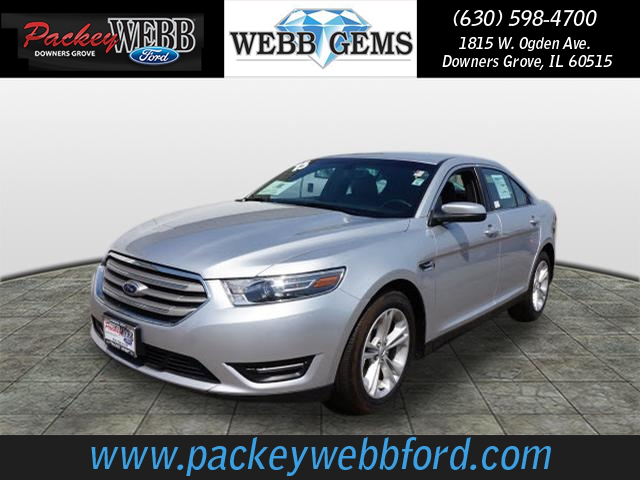

In [4]:
Image.open('/content/Sr_DS_Assgn/data/3_4th_driver_side_front/10002.jpg')

In [5]:
#using path lib for glob 
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/Sr_DS_Assgn/data')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4500


In [7]:
#Each classes with their path
car_images_dict = {
    'Three_4th_driver_side_front': list(data_dir.glob('3_4th_driver_side_front/*')),
    'Three_4th_driver_side_rear': list(data_dir.glob('3_4th_driver_side_rear/*')),
    'Three_4th_passenger_side_front': list(data_dir.glob('3_4th_passenger_side_front/*')),
    'Three_4th_passenger_side_rear': list(data_dir.glob('3_4th_passenger_side_rear/*')),
    'driver_side': list(data_dir.glob('driver_side/*')),
    'front': list(data_dir.glob('front/*')),
    'passenger_side': list(data_dir.glob('passenger_side/*')),
    'rear': list(data_dir.glob('rear/*')),
    'unknown': list(data_dir.glob('unknown/*')),
}

In [8]:
#Labling classes for modeling
car_labels_dict = {'Three_4th_driver_side_front':0,
                       'Three_4th_driver_side_rear':1,
                       'Three_4th_passenger_side_front':2,
                       'Three_4th_passenger_side_rear':3,
                       'driver_side':4,
                       'front':5,
                       'passenger_side':6,
                       'rear':7,
                       'unknown':8
                      }

In [9]:
#Load Data as X - Image, y - Label
X, y = [], []

for car_name, images in car_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(299,299))
        X.append(resized_img)
        y.append(car_labels_dict[car_name])

In [10]:
X[0].shape

(299, 299, 3)

In [11]:
#Splitting Data train - 80%, valid - 10%, test - 10%
from sklearn.model_selection import train_test_split
X_train, X_1, y_train, y_1 = train_test_split(X, y, random_state=0, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_1, y_1, random_state=0,test_size=0.5)

In [12]:
#ImageData Augmentation only for Training data
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  training_images = np.expand_dims(training_images, 0)
  validation_images = np.expand_dims(validation_images, 0)

  print(training_images.shape)
  print(validation_images.shape)

  train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = False,
   )

  train_generator = train_datagen.flow(x=training_images[0],
                                       y=training_labels,
                                       batch_size=32) 

  
  validation_datagen = ImageDataGenerator(
      rescale = 1./255
  )

  validation_generator = validation_datagen.flow(x=validation_images[0],
                                                 y=validation_labels,
                                                 batch_size=32) 

  return train_generator, validation_generator


train_generator, validation_generator = train_val_generators(
    training_images = X_train, 
    training_labels = y_train,
    validation_images = X_valid,
    validation_labels = y_valid,
    )

(1, 3600, 299, 299, 3)
(1, 450, 299, 299, 3)


In [13]:
train_generator.n

3600

In [14]:
validation_generator.n

450

In [15]:
# # Initializing InceptionV3 (pretrained) model with input image shape as (299, 299, 3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299, 3))

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [16]:
base_model

In [17]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(9, activation='softmax') # 9 Output Neurons for 9 Classes
])

In [18]:
#setting learning rate alpha
opt = Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 9)                 9225      
                                                                 
Total params: 23,910,185
Trainable params: 2,107,401
Non-trainable params: 21,802,784
____________________________________

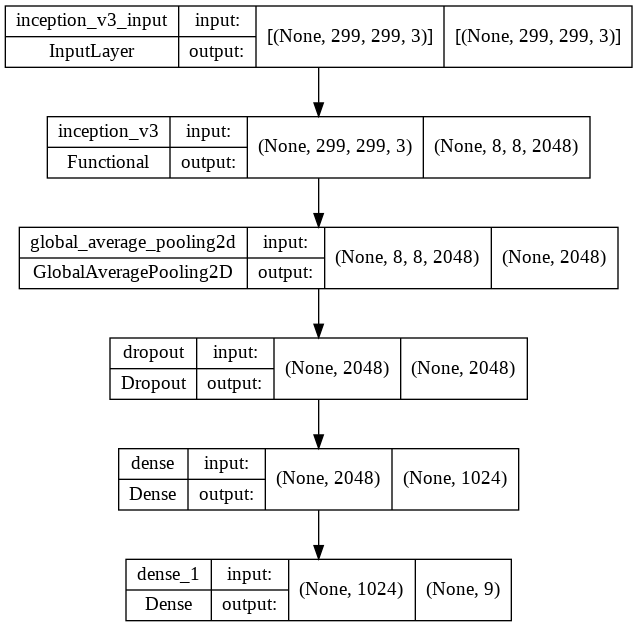

In [20]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
#Assigning steps and epochs
batch_size = 32
epochs = 30

# Seperating Training and Testing Data
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 112
validation_steps : 14


In [22]:
#generated model path
filepath = "model/model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=validation_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
112/112 [==============================] - ETA: 0s - loss: 1.3173 - accuracy: 0.5210
Epoch 1: val_accuracy improved from -inf to 0.60938, saving model to model/model_01-0.61.h5
112/112 [==============================] - 104s 798ms/step - loss: 1.3173 - accuracy: 0.5210 - val_loss: 1.0093 - val_accuracy: 0.6094
Epoch 2/30
112/112 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.6499
Epoch 2: val_accuracy improved from 0.60938 to 0.63616, saving model to model/model_02-0.64.h5
112/112 [==============================] - 79s 706ms/step - loss: 0.8536 - accuracy: 0.6499 - val_loss: 0.8501 - val_accuracy: 0.6362
Epoch 3/30
112/112 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.6875
Epoch 3: val_accuracy improved from 0.63616 to 0.68527, saving model to model/model_03-0.69.h5
112/112 [==============================] - 74s 655ms/step - loss: 0.7534 - accuracy: 0.6875 - val_loss: 0.7443 - val_accuracy: 0.6853
Epoch 4/30
112/112 [=======

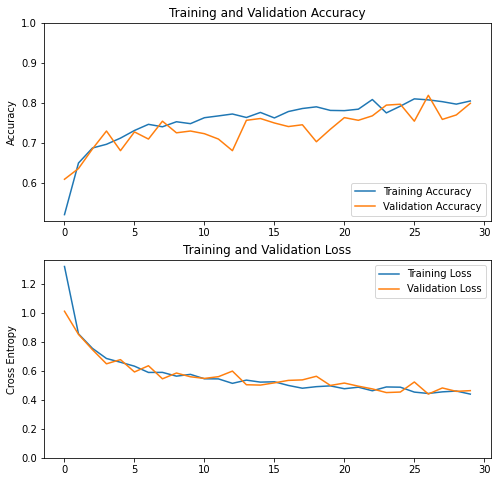

In [23]:
#plotting History of Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [24]:
#Accessing Accuracy metric
test_loss, test_acc = model.evaluate(validation_generator)
print('test accuracy : ', test_acc)

15/15 [==============================] - 3s 196ms/step - loss: 0.4630 - accuracy: 0.7978
test accuracy :  0.7977777719497681


In [26]:
# Pick the best model weights for testing and test it on few images
loaded_best_model = keras.models.load_model("/content/model/model_27-0.82.h5")

# Custom function to load and predict label for the image
def predict(img):
    # Imported Image has the size of (299,299)
    # Scaling the Image Array values between 0 and 1
    resized_img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(resized_img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(resized_img[np.newaxis, ...])

    # Label array
    labels = {value: key for key, value in car_labels_dict.items()}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()


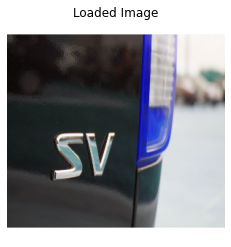



Maximum Probability:  0.99971944
Classified: unknown 



-------------------Individual Probability--------------------------------

THREE_4TH_DRIVER_SIDE_FRONT : 0.0 %
THREE_4TH_DRIVER_SIDE_REAR : 0.0 %
THREE_4TH_PASSENGER_SIDE_FRONT : 0.0 %
THREE_4TH_PASSENGER_SIDE_REAR : 0.0 %
DRIVER_SIDE : 0.0 %
FRONT : 0.02 %
PASSENGER_SIDE : 0.0 %
REAR : 0.01 %
UNKNOWN : 99.97 %


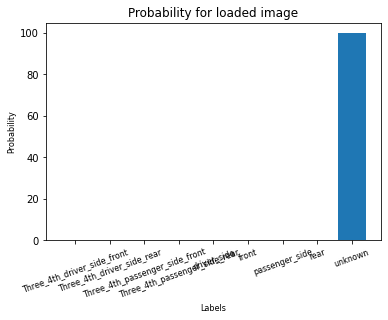

In [27]:
predict(X_test[3])

In [28]:
y_test[3]

8

In [29]:
X_test=np.array(X_test)/255.0

In [30]:
np.argmax(loaded_best_model.predict(X_test[3][np.newaxis, ...]),axis=1).tolist()[0]

8

In [31]:
len(X_test)

450

In [32]:
#storing prediction of X_test
predicted_test=[]
for i in range(len(X_test)):
    predicted_test.append(np.argmax(loaded_best_model.predict(X_test[i][np.newaxis, ...]),axis=1).tolist()[0])

In [33]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_test})
print(df)

     Actual  Predicted
0         1          1
1         6          6
2         6          6
3         8          8
4         4          6
..      ...        ...
445       1          1
446       1          1
447       8          8
448       1          1
449       0          0

[450 rows x 2 columns]


In [34]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score

In [35]:
#overall f1 score
f1_score(y_test, predicted_test, average='macro')

0.7842329613959663

In [36]:
precision, recall, fscore, support = score(y_test, predicted_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.73170732 0.64367816 0.675      0.74193548 0.82926829 0.98214286
 0.625      0.97727273 1.        ]
recall: [0.69767442 0.86153846 0.72972973 0.43396226 0.56666667 1.
 0.86956522 0.97727273 0.9787234 ]
fscore: [0.71428571 0.73684211 0.7012987  0.54761905 0.67326733 0.99099099
 0.72727273 0.97727273 0.98924731]
support: [43 65 37 53 60 55 46 44 47]


In [37]:
df2 = pd.DataFrame({'precision': precision, 'recall': recall, 'F1_score': fscore, 'Support': support})

In [38]:
#All individual scores
df2.rename(index={value: key for key, value in car_labels_dict.items()})

,precision,recall,F1_score,Support
Three_4th_driver_side_front,0.731707,0.697674,0.714286,43
Three_4th_driver_side_rear,0.643678,0.861538,0.736842,65
Three_4th_passenger_side_front,0.675000,0.729730,0.701299,37
Three_4th_passenger_side_rear,0.741935,0.433962,0.547619,53
driver_side,0.829268,0.566667,0.673267,60
front,0.982143,1.000000,0.990991,55
passenger_side,0.625000,0.869565,0.727273,46
rear,0.977273,0.977273,0.977273,44
unknown,1.000000,0.978723,0.989247,47


1. We can try improve the score by trying different transfer learning models listed below:

'efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'nasnet_large', 'pnasnet_large'


2. We can also try to add or reduce o/p layers as well for better accuracy

3. We can try increase the iterations (epochs) to improve the score

P.S. due to consumption of high computational power i have limitedly used 30 epochs we can run more iterations on high performance machines